In [ ]:
!rm -rf sample_data/ #extra space freeing

In [ ]:
!unzip "/content/drive/MyDrive/cs559/SCUT_FBP5500_downsampled.zip"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: test/3_AM653.jpg        
  inflating: test/3_AM666.jpg        
  inflating: test/3_AM682.jpg        
  inflating: test/3_AM702.jpg        
  inflating: test/3_AM716.jpg        
  inflating: test/3_AM741.jpg        
  inflating: test/3_AM751.jpg        
  inflating: test/3_AM767.jpg        
  inflating: test/3_AM780.jpg        
  inflating: test/3_AM794.jpg        
  inflating: test/3_AM810.jpg        
  inflating: test/3_AM827.jpg        
  inflating: test/3_AM837.jpg        
  inflating: test/3_AM848.jpg        
  inflating: test/3_AM865.jpg        
  inflating: test/3_AM884.jpg        
  inflating: test/3_AM899.jpg        
  inflating: test/3_AM909.jpg        
  inflating: test/3_AM919.jpg        
  inflating: test/3_AM933.jpg        
  inflating: test/3_AM954.jpg        
  inflating: test/3_AM978.jpg        
  inflating: test/3_AM989.jpg        
  inflating: test/3_AM998.jpg        
  inflating: test/3_CF115.jpg        
  i

In [ ]:
import tensorflow as tf
import os

def parse_label_from_path(path):
    fname = tf.strings.regex_replace(path, r".*[\\/]", "")          # -> b"7_CM668.jpg"
    # 2) grab the leading integer before the underscore
    num   = tf.strings.regex_replace(fname, r"^([0-9]+)_.*$", r"\1")# -> b"7"
    # 3) to float and shape (1,) for regression
    label = tf.strings.to_number(num, out_type=tf.float32)
    return tf.reshape(label, [1])  # regression target shape [1]

def process_img(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, (80, 80)) / 255.0
    y = parse_label_from_path(path)
    return img, y  # <-- (features, label)

train_dataset = (tf.data.Dataset.list_files("training/*.jpg")).map(process_img).prefetch(tf.data.AUTOTUNE)
validation_dataset = (tf.data.Dataset.list_files("validation/*.jpg")).map(process_img).prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf

print("train cardinality:", tf.data.experimental.cardinality(train_dataset))
print("val cardinality  :", tf.data.experimental.cardinality(validation_dataset))
print("test cardinality :", tf.data.experimental.cardinality(test_dataset))

for xb, yb in train_dataset.batch(32).take(1):
    print("first train batch:", xb.shape, yb.shape)
for xb, yb in train_dataset.batch(32).skip(111).take(1):  # last step
    print("last  train batch:", xb.shape, yb.shape)       # expect (3, 80, 80, 3)

train cardinality: tf.Tensor(3555, shape=(), dtype=int64)
val cardinality  : tf.Tensor(893, shape=(), dtype=int64)


NameError: name 'test_dataset' is not defined

In [ ]:
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
%ls training | wc -l
%ls validation | wc -l
%ls test | wc -l

3555
893
895


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L, Model
class AttractRegressorModel(Model):
    def __init__(self, architecture:dict):
        super().__init__()
        self.architecture = architecture
        self.layer_list = self._build_model(architecture)
        self.is_sequential = self.architecture.get("computation_sequence", "sequential") == "sequential"
        if self.is_sequential:
          self.layer_list = tf.keras.Sequential(self.layer_list)
        #for residuality
        self.residual_map = {}
        self.required_outputs = set()
        if not self.is_sequential:
            self._parse_computation_sequence()

    def _parse_computation_sequence(self, architecture):
        computation_sequence = self.architecture.get("computation_sequence")
        for conn_str in computation_sequence:
            try:
                start, end = map(int, conn_str.split('-'))
                if start >= end:
                    raise ValueError(f"Start index ({start}) must be less than end index ({end}) in connection '{conn_str}'.")

                # Map the end point to the start point for quick lookups
                self.residual_map[end] = start

                # We need to store the output of the layer *before* the start index
                self.required_outputs.add(start - 1)
                print(f"  - Will add output of layer {start - 1} to output of layer {end}")

            except ValueError as e:
                raise ValueError(f"Invalid connection format: '{conn_str}'. Expected 'start-end'. Details: {e}")

    def _build_cnn_layer(self,params):
      return L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            kernel_initializer=params.get("initialization", "he_normal"),
            kernel_regularizer=tf.keras.regularizers.l2(params.get("l2_rate", 0)), # Zero means no regularizer
            use_bias=True
        ) if "dilation" not in params else L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            dilation_rate=params.get("dilation", 1),
            use_bias=True
        )

    def _build_maxpool_layer(self,params):
      return L.MaxPooling2D(
            pool_size=params.get("pool_size", 2),
            strides=params.get("strides", 2)
        )

    def _build_batchnorm_layer(self,layer):
      return L.BatchNormalization()

    def _build_activation_layer(self, params: dict):
        name = params.get("name", "relu").lower()
        if name == 'leakyrelu':
            return L.LeakyReLU(alpha=params.get("alpha", 0.1))
        return L.Activation(name)

    def _build_dropout_layer(self, params):
      return L.Dropout(rate=params.get("rate", 0.5))

    def _build_last_layer(self, params: dict):
      """
      Builds the final block of the network (the head).
      This can be a multi-layer sequence, so it returns a Sequential model.
      """
      head_type = params.get("head_type", "mlp") # Default to mlp
      if head_type == "mlp":
        print("  - Building MLP Head (Flatten -> Dense)")
        return tf.keras.Sequential([L.Flatten(),
                                    # L.Dense(4096),
                                    # L.Dense(4096, kernel_regularizer= tf.keras.regularizers.l2(params.get("l2_rate", 0))),
                                    L.Dense(1, kernel_regularizer= tf.keras.regularizers.l2(params.get("l2_rate", 0)))])
      elif head_type == "fully_convolutional":
        print("  - Building FCN Head (GlobalAvgPool -> Dense)")
        return tf.keras.Sequential([
            L.GlobalAveragePooling2D(),
            L.Dense(64, activation="relu"),
            L.Dense(1)
        ])
      else:
        raise ValueError(f"Unknown last_layer head_type: {head_type}")

    def _build_model(self,architecture):
      modules = []
      build_maps = {
          "cnn": self._build_cnn_layer,
          "maxpool": self._build_maxpool_layer,
          "batchnorm": self._build_batchnorm_layer,
          "activation": self._build_activation_layer,
          "last_layer": self._build_last_layer,
          "dropout": self._build_dropout_layer
      }
      for module in architecture["layers"]:
          build_function = build_maps[module["type"]]
          layer = build_function(module)
          modules.append(layer)
      return modules

    def debug_initializers(self):
        print("\n--- Weight Initializers ---")

        layers = self.layer_list.layers if isinstance(self.layer_list, tf.keras.Sequential) else self.layer_list

        for layer in layers:
            if hasattr(layer, "kernel_initializer"):
                print(f"{layer.name}: {type(layer.kernel_initializer).__name__}")


    def call(self, inputs, training=False):
        # Sequential Operations
        if self.is_sequential:
            return self.layer_list(inputs, training=training)

        # If there are skip connections:
        outputs_cache = {}
        x = inputs
        # Check if the initial input tensor needs to be stored for a connection
        if 0 in self.required_outputs:
            outputs_cache[0] = x

        # --- Main Forward Pass with Inline Additions ---
        for i, layer in enumerate(self.layer_list): ## even though Activations are not a layer we treated as it is.
            layer_num = i + 1

            # Forward passing
            x = layer(x, training=training)

            # If this layer is an endpoint for a residual connection, perform the addition
            if layer_num in self.residual_map:
                start_idx = self.residual_map[layer_num]

                if (start_idx - 1) not in outputs_cache:
                    raise RuntimeError(f"Logic error: Required output from layer {start_idx - 1} was not cached.")

                shortcut_path = outputs_cache[start_idx - 1]

                # --- Shape Validation ---
                if x.shape[1:] != shortcut_path.shape[1:]:
                    raise ValueError(
                        f"Shape mismatch for residual connection {start_idx}-{layer_num}. "
                        f"Cannot add shortcut shape {shortcut_path.shape} to main shape {x.shape}. "
                        "You may need a projection layer (1x1 Conv) to match dimensions."
                    )

                # Perform the addition, which now becomes the main path tensor 'x'
                x = L.Add()([x, shortcut_path])

            # Check if the activation output is the residual for feature
            if layer_num in self.required_outputs:
                outputs_cache[layer_num] = x

        return x

In [ ]:
def visualize_model(vgg_model):
  dummy = tf.zeros([1, 80, 80, 3], dtype=tf.float32)
  _ = vgg_model(dummy, training=False)

  # 2) Print a readable summary
  vgg_model.summary()

  # 3) Make a functional wrapper so you can export a graph plot
  inp = tf.keras.Input(shape=(80, 80, 3), name="image_80x80x3")
  out = vgg_model(inp, training=False)
  vgg_func = Model(inp, out, name="AttractRegressor_VGGx5")

  # 4) Plot the graph (PNG) with shapes
  tf.keras.utils.plot_model(
      vgg_func,
      to_file="vggx5_graph.png",
      show_shapes=True,
      show_layer_names=True,
      expand_nested=True,
      dpi=180
  )

In [ ]:
from tensorflow.keras import callbacks
from tqdm import tqdm
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "mlp"}
     #
]
vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

# vgg16_dilated_layers = [
#     # Block 1 (same)
#     {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "maxpool", "pool_size": 2, "strides": 2},

#     # Block 2 (same)
#     {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "maxpool", "pool_size": 2, "strides": 2},


#     # Block 4 (dilated; no pool)
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},

#     # Block 5 (stronger dilation; no pool)
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "last_layer", "head_type": "mlp"}
# ]
# vgg_dilated_layers_config = {
#     "layers": vgg16_dilated_layers,
#     "computation_sequence": "sequential"
# }


def make_toy_subset_train(ds, k=30, batch_size=8, seed=1337):
    # Shuffle & take k samples once, then cache & repeat forever for fast epochs
    toy = (ds
           .shuffle(4096, seed=seed, reshuffle_each_iteration=False)
           .take(k)
           .cache()
           .repeat()
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))
    steps_per_epoch = max(1, k // batch_size)
    return toy, steps_per_epoch
@tf.function
def rounded_mae(y_true, y_pred):
    y_pred_r = tf.round(y_pred)
    return tf.reduce_mean(tf.abs(y_true - y_pred_r))

def plot_toy_history(hist, title="Toy overfit"):
    epochs = range(1, len(hist["loss"])+1)

    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, hist["loss"], label="train loss (MSE)")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training loss"); plt.grid(True, alpha=0.3)
    # MSE
    plt.subplot(1,3,2)
    plt.plot(epochs, hist["mse"], label="MSE")
    plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Train MSE"); plt.grid(True, alpha=0.3)
    # MAE metrics
    plt.subplot(1,3,3)
    if "mae_unrounded" in hist:
        plt.plot(epochs, hist["mae_unrounded"], label="MAE (unrounded)")
    if "rounded_mae" in hist:
        plt.plot(epochs, hist["rounded_mae"], label="MAE (rounded)")
    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("Train MAE"); plt.grid(True, alpha=0.3)
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

class SingleBar(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(
            total=self.params['epochs'],
            desc='training',
            leave=False,              # keeps it to a single rolling line
            dynamic_ncols=True,
            bar_format='{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}'
        )

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        tail = {k: f"{logs[k]:.4f}" for k in ("loss","mse","rounded_mae") if k in logs}
        # 1) set postfix WITHOUT forcing an immediate refresh
        self.pbar.set_postfix(tail, refresh=False)
        # 2) now advance the bar (this triggers a single refresh)
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

def toy_overfit_run(model, train_ds_full, k=30, epochs=200, batch_size=8, lr=1e-3, name="model"):
    toy_ds, steps_per_epoch = make_toy_subset_train(train_ds_full, k=k, batch_size=batch_size)

    # Build the model by calling once (subclassed model needs a shape)
    sample_x, _ = next(iter(toy_ds))
    _ = model(sample_x, training=False)

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse",
                  metrics=[tf.keras.metrics.MeanSquaredError(name="mse"), tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None),rounded_mae
])

    print(f"\n[toy] Training {name} on {k} samples | lr={lr} | bs={batch_size} | epochs={epochs}")
    hist = model.fit(
        toy_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=0,
        callbacks=[
            SingleBar(),callbacks.TerminateOnNaN(),
        ],
    ).history
    plot_toy_history(hist, title=f"Toy {name} overfit")
    final_mse   = float(hist["mse"][-1])
    final_mae   = float(hist["mean_absolute_error"][-1])
    final_rmae  = float(hist["rounded_mae"][-1])

    # Simple “did it memorize?” rule of thumb:
    # rounded MAE <= 0.1 means almost perfect rounding; MSE <= 1e-3 also a good sign.
    ok = (final_rmae <= 0.1) or (final_mse <= 1e-3)
    best_idx_loss  = int(tf.argmin(hist["loss"], axis=0).numpy())
    best_idx_mse   = int(tf.argmin(hist["mse"], axis=0).numpy())
    best_idx_rmae  = int(tf.argmin(hist["rounded_mae"], axis=0).numpy())

    print(f"[toy][{name}] last:  MSE={final_mse:.5f} | MAE(unr)={final_mae:.4f} | rMAE={final_rmae:.4f} | overfit_ok={ok}")
    print(f"[toy][{name}] best epochs: loss@{best_idx_loss}, mse@{best_idx_mse}, rMAE@{best_idx_rmae}")
    return hist, ok


# vgg_model = AttractRegressorModel(vgg16_config)
# _,_ = toy_overfit_run(vgg_model, train_dataset, k=30, epochs=150, batch_size=30, lr=1e-4, name="vgg16")
# vgg_dilated = AttractRegressorModel(vgg_dilated_layers_config)
# _,_ = toy_overfit_run(vgg_dilated,train_dataset, k=30, epochs=150, batch_size=30, lr=1e-4, name="vgg16 dilated" )
# visualize_model(vgg_model)

In [ ]:
general_learning_rate = 3e-4
general_batch_size = 8
general_epochs= 150

In [ ]:
from tensorflow.keras import losses

loss_function = "mse"
# or loss_function = losses.MeanSquaredError()

In [ ]:
#Training with the whole data

# ====== plotting: train + val ======
import matplotlib.pyplot as plt

def plot_train_val_history(hist, title="Training"):
    e = range(1, len(hist["loss"])+1)

    plt.figure(figsize=(13,6))

    # Loss (MSE loss)
    plt.subplot(1,2,1)
    plt.plot(e, hist["loss"], label="train loss")
    if "val_loss" in hist: plt.plot(e, hist["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("MSE loss"); plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()

    # MAE (rounded)
    plt.subplot(1,2,2)
    # If you also log unrounded MAE, you can plot it too; here we focus on rounded MAE per the assignment
    if "rounded_mae" in hist:       plt.plot(e, hist["rounded_mae"], label="train rMAE")
    if "val_rounded_mae" in hist:   plt.plot(e, hist["val_rounded_mae"], label="val rMAE")
    # (optionally show unrounded)
    if "mean_absolute_error" in hist:        plt.plot(e, hist["mean_absolute_error"], '--', alpha=0.5, label="train MAE")
    if "val_mean_absolute_error" in hist:    plt.plot(e, hist["val_mean_absolute_error"], '--', alpha=0.5, label="val MAE")

    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def prepare_train(ds, batch_size=32, seed=1337):
    return (ds
            .shuffle(8192, seed=seed, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

def prepare_val(ds, batch_size=32):
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
from IPython.display import clear_output

# Useful utility tool for adding l2 regularization to layers
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers

class LivePlot(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.h = {"loss":[], "val_loss":[], "mean_absolute_error":[], "val_mean_absolute_error":[]}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.h.keys():
            if k in logs: self.h[k].append(logs[k])
        clear_output(wait=True)
        e = range(1, len(self.h["loss"])+1)
        plt.figure(figsize=(13,6))
        # Loss
        plt.subplot(1,2,1)
        plt.plot(e, self.h["loss"], label="train loss")
        if self.h["val_loss"]: plt.plot(e, self.h["val_loss"], label="val loss")
        plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()
        # MAE
        plt.subplot(1,2,2)
        if self.h["mean_absolute_error"]: plt.plot(e, self.h["mean_absolute_error"], '--', label="train MAE")
        if self.h["val_mean_absolute_error"]: plt.plot(e, self.h["val_mean_absolute_error"], '--', label="val MAE")
        plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()
def train_with_val(model,
                   train_ds_full,
                   val_ds_full,
                   epochs=100,
                   batch_size=32,
                   lr=1e-3,
                   name="model",
                   early_stop=True):
    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # Build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    # For debugging:
    for layer in model.layers:
      if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer:
        print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt, loss=loss_function,
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    model.debug_initializers()

    cbs = [LivePlot(),SingleBar(), callbacks.TerminateOnNaN()]

    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(monitor="val_mean_absolute_error", factor=0.5, patience=10, min_lr=1e-6, verbose=1, mode='min'),
            callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True, verbose=1, mode='min'),
        ]

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,                 # SingleBar drives the progress
        callbacks=cbs
    ).history
    print(h["val_loss"])
    # summary
    last = {
        "loss": h["loss"][-1],
        "val_loss": h.get("val_loss", float("nan"))[-1],
        "mean_absolute_error": h.get("mean_absolute_error", [float("nan")])[-1],
        "val_mean_absolute_error": h.get("val_mean_absolute_error", [float("nan")])[-1],
    }
    print(last)
    print(f"[{name}] last: loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"rMAE={last['mean_absolute_error']:.4f} | val_rMAE={last['val_mean_absolute_error']:.4f}")

    # plot
    plot_train_val_history(h, title=f"{name} train/val")

    return h



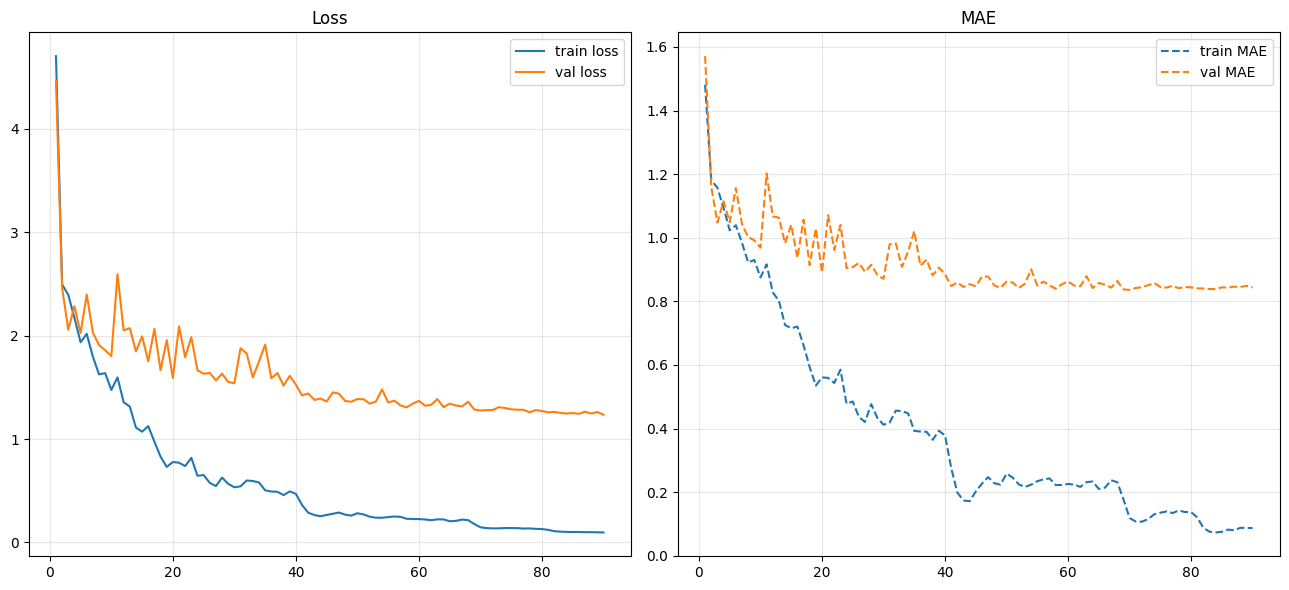

training:  60%|██████     90/150 [24:51<16:15] , loss=0.0969, mse=0.0122


Epoch 90: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 70.


[4.460236549377441, 2.461958885192871, 2.056809186935425, 2.2852671146392822, 2.0256736278533936, 2.3971402645111084, 2.02921462059021, 1.9083586931228638, 1.8583906888961792, 1.8021507263183594, 2.59373140335083, 2.051112413406372, 2.072254180908203, 1.847599983215332, 1.9935897588729858, 1.7523478269577026, 2.06478214263916, 1.6664929389953613, 1.957146406173706, 1.5908467769622803, 2.089235544204712, 1.7913687229156494, 1.9850106239318848, 1.665289044380188, 1.6316263675689697, 1.6395573616027832, 1.5671663284301758, 1.632865309715271, 1.5512583255767822, 1.5402932167053223, 1.878339409828186, 1.828137993812561, 1.596129298210144, 1.749140739440918, 1.912838101387024, 1.587609887123108, 1.6383843421936035, 1.5169284343719482, 1.6107745170593262, 1.5256868600845337, 1.4211856126785278, 1.4399356842041016, 1.3788777589797974, 1.3916380405426025, 1.363515853881836, 1.4509704113006592, 1.4394617080688477, 1.3684108257293701, 1.3607959747314453, 1.38673996925354, 1.3856470584869385, 1.34

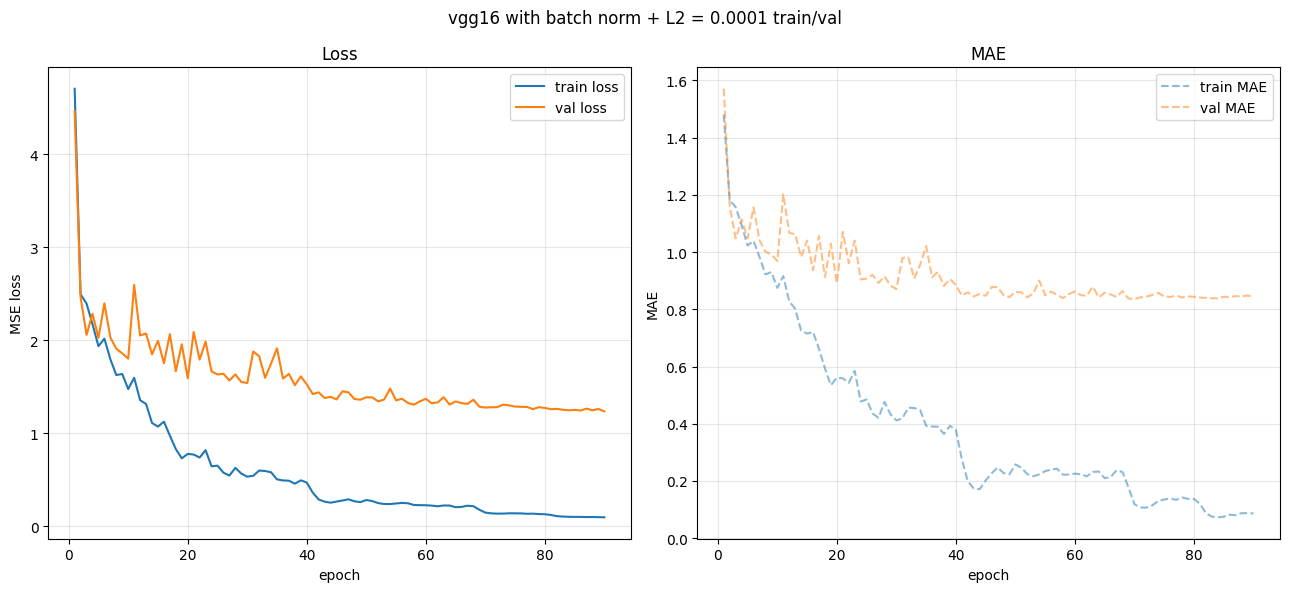

In [ ]:
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},


    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "mlp"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with batch norm + L2 = " + str(l2_rate)
)

In [ ]:
visualize_model(vgg_model)

Model: "attract_regressor_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (8, 80, 80, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (8, 80, 80, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (8, 80, 80, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (8, 80, 80, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (8, 80, 80, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (8, 80, 80, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (8, 40, 40, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (8, 40, 40, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (8, 40, 40, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (8, 40, 40, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (8, 40, 40, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (8, 40, 40, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (8, 40, 40, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (8, 20, 20, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (8, 20, 20, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (8, 20, 20, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (8, 20, 20, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (8, 20, 20, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (8, 20, 20, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (8, 20, 20, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (8, 20, 20, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (8, 20, 20, 256)       │         1,02

 Total params: 22,965,701 (87.61 MB)

 Trainable params: 7,653,441 (29.20 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 15,306,884 (58.39 MB)

In [ ]:
test_dataset = (
    tf.data.Dataset.list_files("test/*.jpg")
    .map(process_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(general_batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

results = vgg_model.evaluate(test_dataset, return_dict=True)
print("Test MSE:", results["mse"])
print("Test MAE:", results["mean_absolute_error"])


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2823 - mean_absolute_error: 0.8023 - mse: 1.1597
Test MSE: 1.122033953666687
Test MAE: 0.8041505813598633


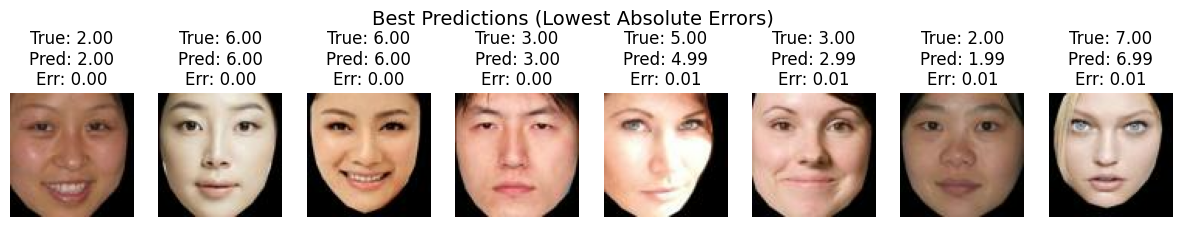

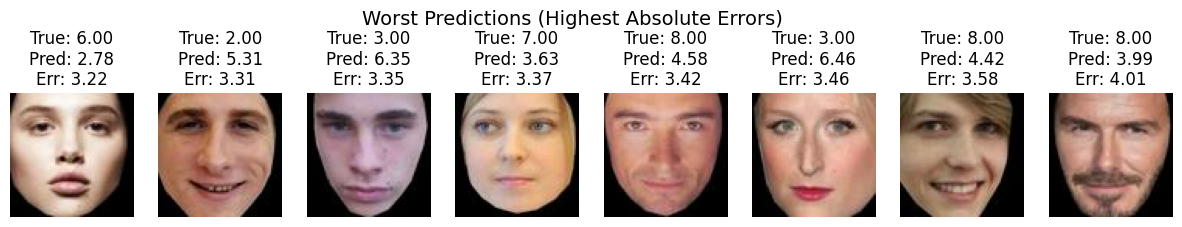

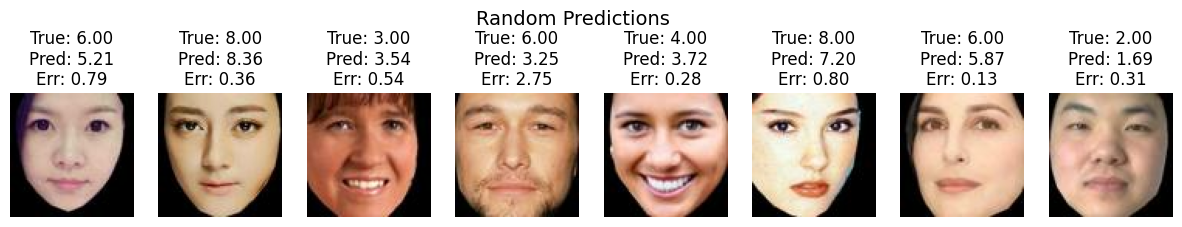

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_predictions(model, test_dataset, num_examples=5):
    # Collect all images, labels, and predictions
    all_images, all_labels, all_preds = [], [], []

    for batch_imgs, batch_labels in test_dataset:
        preds = model.predict(batch_imgs, verbose=0)
        all_images.append(batch_imgs.numpy())
        all_labels.append(batch_labels.numpy())
        all_preds.append(preds)

    # Concatenate everything
    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels).flatten()
    all_preds = np.concatenate(all_preds).flatten()

    # Compute absolute errors
    errors = np.abs(all_preds - all_labels)
    sorted_idx = np.argsort(errors)

    # Choose subsets
    best_idx = sorted_idx[:num_examples]
    worst_idx = sorted_idx[-num_examples:]
    random_idx = np.random.choice(len(all_images), num_examples, replace=False)

    # Helper function to plot examples
    def plot_examples(indices, title):
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(all_images[idx])
            plt.axis("off")
            plt.title(f"True: {all_labels[idx]:.2f}\nPred: {all_preds[idx]:.2f}\nErr: {errors[idx]:.2f}")
        plt.suptitle(title, fontsize=14)
        plt.show()

    # Show best, worst, and random predictions
    plot_examples(best_idx, f"Best Predictions (Lowest Absolute Errors)")
    plot_examples(worst_idx, f"Worst Predictions (Highest Absolute Errors)")
    plot_examples(random_idx, f"Random Predictions")

show_predictions(vgg_model, test_dataset, num_examples=8)

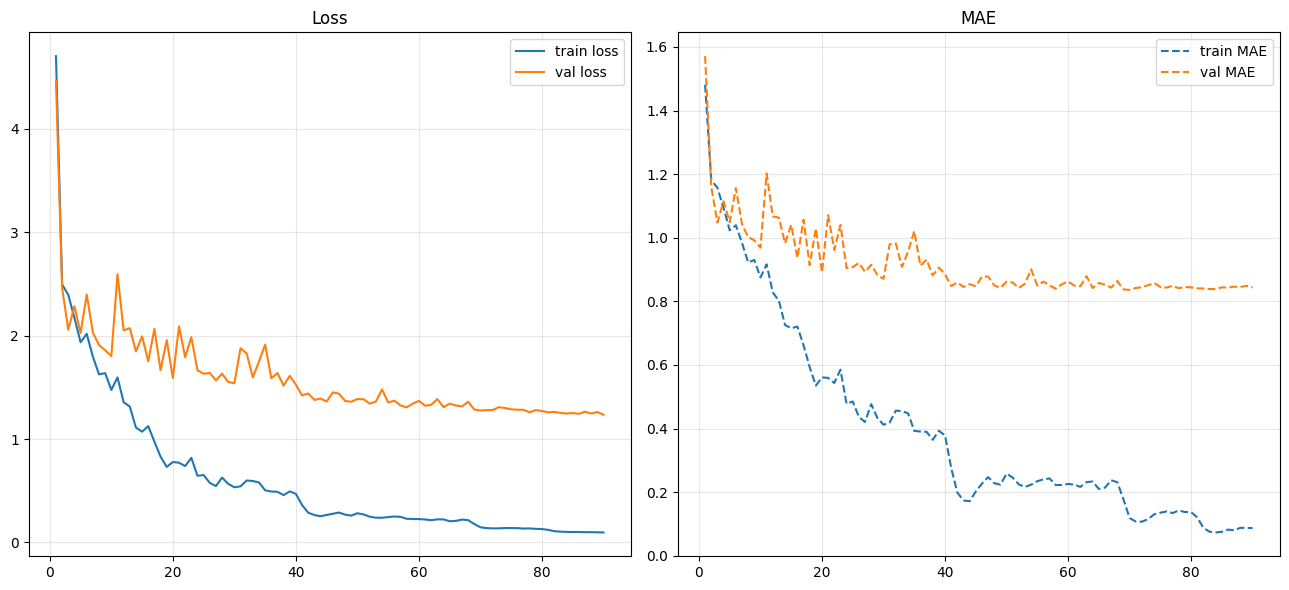

training:  60%|██████     90/150 [24:51<16:15] , loss=0.0969, mse=0.0122


Epoch 90: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 70.


[4.460236549377441, 2.461958885192871, 2.056809186935425, 2.2852671146392822, 2.0256736278533936, 2.3971402645111084, 2.02921462059021, 1.9083586931228638, 1.8583906888961792, 1.8021507263183594, 2.59373140335083, 2.051112413406372, 2.072254180908203, 1.847599983215332, 1.9935897588729858, 1.7523478269577026, 2.06478214263916, 1.6664929389953613, 1.957146406173706, 1.5908467769622803, 2.089235544204712, 1.7913687229156494, 1.9850106239318848, 1.665289044380188, 1.6316263675689697, 1.6395573616027832, 1.5671663284301758, 1.632865309715271, 1.5512583255767822, 1.5402932167053223, 1.878339409828186, 1.828137993812561, 1.596129298210144, 1.749140739440918, 1.912838101387024, 1.587609887123108, 1.6383843421936035, 1.5169284343719482, 1.6107745170593262, 1.5256868600845337, 1.4211856126785278, 1.4399356842041016, 1.3788777589797974, 1.3916380405426025, 1.363515853881836, 1.4509704113006592, 1.4394617080688477, 1.3684108257293701, 1.3607959747314453, 1.38673996925354, 1.3856470584869385, 1.34

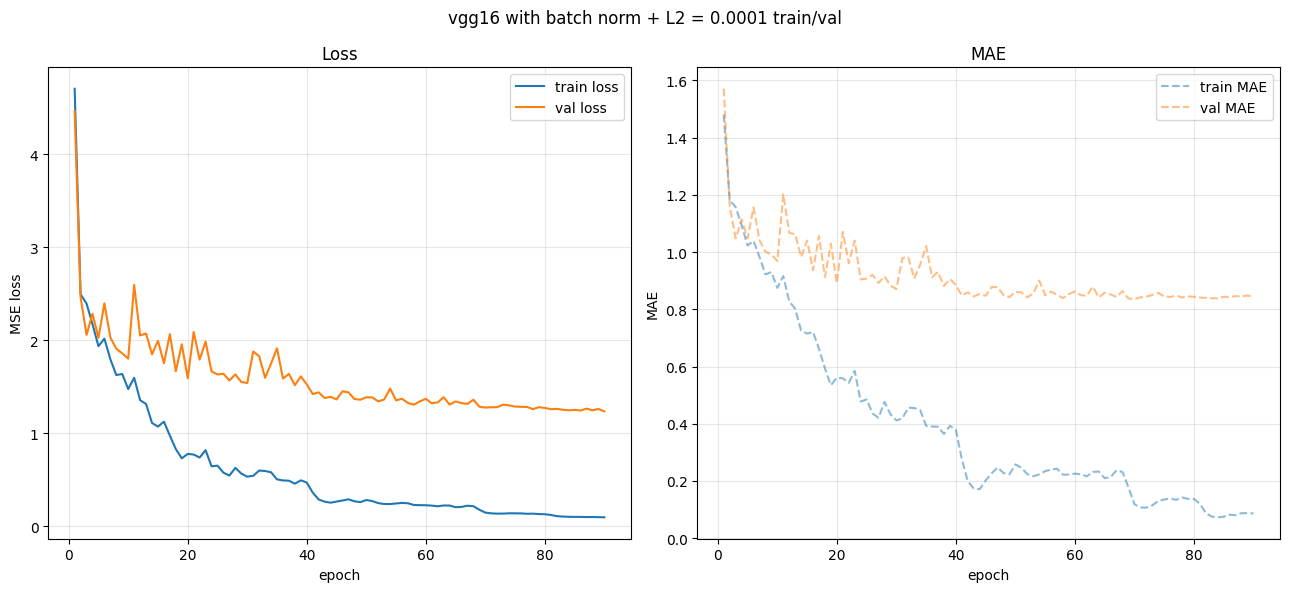

In [ ]:
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},


    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "mlp"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with batch norm + L2 = " + str(l2_rate)
)

In [ ]:
visualize_model(vgg_model)

Model: "attract_regressor_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (8, 80, 80, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (8, 80, 80, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (8, 80, 80, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (8, 80, 80, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (8, 80, 80, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (8, 80, 80, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (8, 40, 40, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (8, 40, 40, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (8, 40, 40, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (8, 40, 40, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (8, 40, 40, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (8, 40, 40, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (8, 40, 40, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (8, 20, 20, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (8, 20, 20, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (8, 20, 20, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (8, 20, 20, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (8, 20, 20, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (8, 20, 20, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (8, 20, 20, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (8, 20, 20, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (8, 20, 20, 256)       │         1,02

 Total params: 22,965,701 (87.61 MB)

 Trainable params: 7,653,441 (29.20 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 15,306,884 (58.39 MB)

In [ ]:
test_dataset = (
    tf.data.Dataset.list_files("test/*.jpg")
    .map(process_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(general_batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

results = vgg_model.evaluate(test_dataset, return_dict=True)
print("Test MSE:", results["mse"])
print("Test MAE:", results["mean_absolute_error"])


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2823 - mean_absolute_error: 0.8023 - mse: 1.1597
Test MSE: 1.122033953666687
Test MAE: 0.8041505813598633


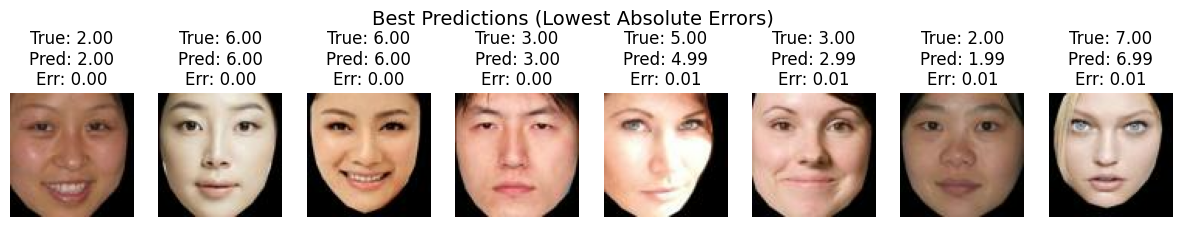

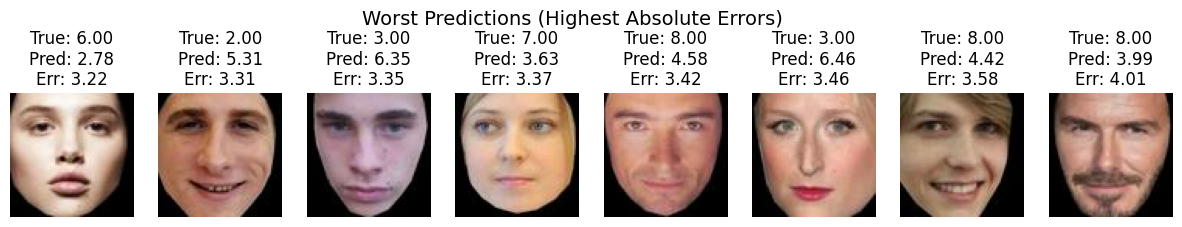

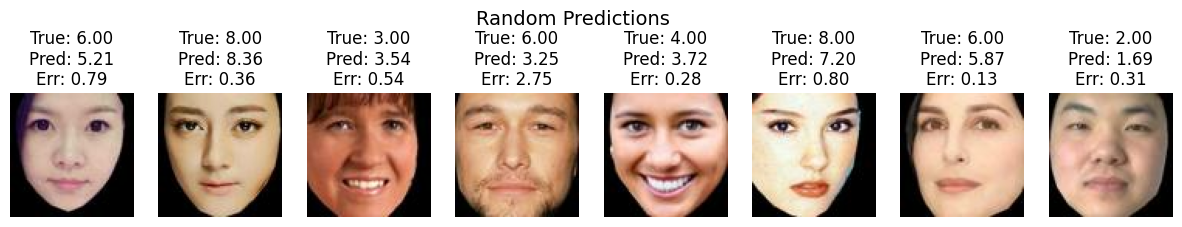

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_predictions(model, test_dataset, num_examples=5):
    # Collect all images, labels, and predictions
    all_images, all_labels, all_preds = [], [], []

    for batch_imgs, batch_labels in test_dataset:
        preds = model.predict(batch_imgs, verbose=0)
        all_images.append(batch_imgs.numpy())
        all_labels.append(batch_labels.numpy())
        all_preds.append(preds)

    # Concatenate everything
    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels).flatten()
    all_preds = np.concatenate(all_preds).flatten()

    # Compute absolute errors
    errors = np.abs(all_preds - all_labels)
    sorted_idx = np.argsort(errors)

    # Choose subsets
    best_idx = sorted_idx[:num_examples]
    worst_idx = sorted_idx[-num_examples:]
    random_idx = np.random.choice(len(all_images), num_examples, replace=False)

    # Helper function to plot examples
    def plot_examples(indices, title):
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(all_images[idx])
            plt.axis("off")
            plt.title(f"True: {all_labels[idx]:.2f}\nPred: {all_preds[idx]:.2f}\nErr: {errors[idx]:.2f}")
        plt.suptitle(title, fontsize=14)
        plt.show()

    # Show best, worst, and random predictions
    plot_examples(best_idx, f"Best Predictions (Lowest Absolute Errors)")
    plot_examples(worst_idx, f"Worst Predictions (Highest Absolute Errors)")
    plot_examples(random_idx, f"Random Predictions")

show_predictions(vgg_model, test_dataset, num_examples=8)